#3D Data Transformation
---------------------------
By : Juan C. Peña and Eberto Benjumea

**(Pending documentation)**

------------------------------------
# Installing dependences

In [ ]:
#@title
%%capture
!pip install deeptrack

In [ ]:
#@title
%%capture
!pip install geopandas

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
import cv2
import random
import scipy.io
%matplotlib inline
import numpy as np
import deeptrack as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import img_as_float
from shapely.geometry import Point
from matplotlib.patches import Rectangle
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
#@title
class Preprocessor():

  def __init__(self,
               scales=[1, 2, 4]
               ):
    self.scales = scales

  
  def crop(self, image, x, y, wide):
    cropped_image = image[y: y + wide, x: x + wide]

    return cropped_image

  def normalizate(self, image):
    normalized_image = (image - np.quantile(image, 0.01))/ (np.quantile(image, 0.99) - np.quantile(image, 0.01))
    # NaN detection
    nan_mask = np.isnan(normalized_image)
    normalized_image[nan_mask] = 0
    
    return normalized_image

  def resize(self, image, scale):
    resized_image = cv2.resize(image, (0, 0), fx=1/scale, fy=1/scale)

    return resized_image

  def generate_pipeline(self, data, transformations):
    pipeline = None
    for transformation in transformations:
        if pipeline is None:
            pipeline = transformation
        else:
            pipeline = pipeline >> transformation

    return pipeline

  def create_train_data(self, data, transformations):
    # data -> an image o a list of images
    normalized_images = [self.normalizate(image) for image in data]
    training_images = [np.expand_dims(image, axis = -1) for image in normalized_images]

    pipeline = self.generate_pipeline(training_images, transformations)
    train_set = dt.Value(lambda: np.array(random.choice(training_images))) >> pipeline
    train_set.plot()

    return train_set

  def load_images(self, data, plot=True):
    dataset = [self.resize(data, scale) for scale in self.scales]
    input_set = [self.normalizate(image) for image in dataset]

    if plot:
      fig, ax = plt.subplots(1, len(input_set), figsize=(25,5))
      fig.tight_layout()
      fig.suptitle('Scaled 3D images')
      for index in range(len(input_set)):
        ax[index].imshow(input_set[index])
    
    return input_set

# --------------------------------------------------------------------
class Trainer():

  def __init__(self,
               filepath,
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               callbacks = [None]
               ):

    self.model = model
    self.filepath = filepath
    self.callbacks = [
        ModelCheckpoint(filepath=self.filepath,
                        save_weights_only=True,
                        monitor='consistency_loss',
                        mode='min',
                        save_best_only=True
                        ),
        EarlyStopping(monitor="total_loss",
                      patience=15,
                      verbose=1,
                      mode="auto",
                      restore_best_weights=True
                      ),
        LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))
    ]
  
  def fit(self, train_set, epochs=40, batch_size=8):
    history = self.model.fit(
        train_set,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = self.callbacks)

    return history

  def plot_performance(self, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    fig.suptitle('Total loss and consistency loss')

    ax1.plot(history.history['total_loss'])
    ax1.set_title('Total loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_ylim([0, 1.5])

    ax2.plot(history.history['consistency_loss'])
    ax2.set_title('Consitency loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.set_ylim([0, 1.5])

    plt.show()

# --------------------------------------------------------------------
class Detector():

  def __init__(self,
               downsample,
               alpha = 0.1,
               cutoff = 0.998,
               mode = "quantile",
               colors = 'rgb',
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               ):
    self.downsample = downsample
    self.alpha = alpha
    self.cutoff = cutoff
    self.mode = mode
    self.colors = colors
    self.model = model

  def detect(self, image, plot=True):
    test_set = image[np.newaxis, :, :, np.newaxis]
    test_image = test_set[:, ::self.downsample, ::self.downsample, :]

    detections = self.model.predict_and_detect(test_image, alpha=self.alpha, beta=1-self.alpha, cutoff=self.cutoff, mode=self.mode)[0]
    detections[:, 1] = detections[:, 1] * self.downsample
    detections[:, 0] = detections[:, 0] * self.downsample

    return detections

  def detect_all(self, images, plot=False):
    detections = []
    
    if plot:
      fig, ax = plt.subplots(1, len(images), figsize=(25, 5))
      fig.tight_layout()
      fig.suptitle('Detections')
    
    for index in range(len(images)):
      det = self.detect(image=images[index])
      detections.append(det)

      if plot:
        ax[index].imshow(images[index])
        ax[index].scatter(detections[index][:, 1], detections[index][:, 0], color=self.colors[index])
      
    return detections

# --------------------------------------------------------------------
class Postprocessor():

  def __init__(self,
               wide=50,
               scales=[1, 2, 4],
               colors = 'rgb'
               ):
    self.wide = wide
    self.scales = scales
    self.colors = colors
  
  def scale_detections(self, detection, scale):
    scaled_detection = detection * scale

    return scaled_detection.tolist()

  def create_boxes(self, detections):
    list_detections = [Point((x,y)) for (y,x) in detections]
    points = gpd.GeoSeries(list_detections)
    boxes = points.buffer(self.wide, cap_style = 3)
    bounds = np.array([boxes[index].bounds for index in range(len(boxes))])

    return boxes, bounds

  def NMSupression(self, boxes, overlapThresh):
    # Malisiewicz et al. - non_max_suppression_fast
    if len(boxes) == 0:
      return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])

      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
      
    return boxes[pick].astype("int")

  def apply_nms(self, image, list_bounds, figsize = (15,15), overlapThresh=0.3):
    all_bounds = [bounds.tolist() for bounds in list_bounds]
    final_bounds = []

    for index in range(len(all_bounds)):
      final_bounds += all_bounds[index]

    final_bounds = np.array(final_bounds)
    final_detections = self.NMSupression(final_bounds,
                                         overlapThresh=overlapThresh)
    self.plot_results(image, final_detections, figsize)

    return final_detections


  def plot_boxes(self, test_image, detections, figsize=(15, 15), plot=True):
    list_boxes, list_bounds, scaled_detections = [], [], []

    if plot:
      fig, ax = plt.subplots(figsize=figsize)
      plt.imshow(test_image)

    for index in range(len(detections)):
      scaled_det = self.scale_detections(detections[index], self.scales[index])
      scaled_detections.append(scaled_det)

      boxes, bounds = self.create_boxes(scaled_detections[index])
      list_boxes.append(boxes)
      list_bounds.append(bounds)

      if plot:
        boxes.boundary.plot(ax=ax, color = self.colors[index])

    return list_bounds

  def plot_results(self, image, boxes, figsize, color='red', lw=2):
    plt.figure(figsize=figsize)
    plt.imshow(image)

    wide = self.wide * 2
    for i in range(len(boxes)):
      rect = Rectangle((boxes[i][0], boxes[i][1]),wide,wide,
                       edgecolor=color,
                       facecolor='none',
                       lw=lw)
     
      plt.gca().add_patch(rect)

------------------------------------
# Settings

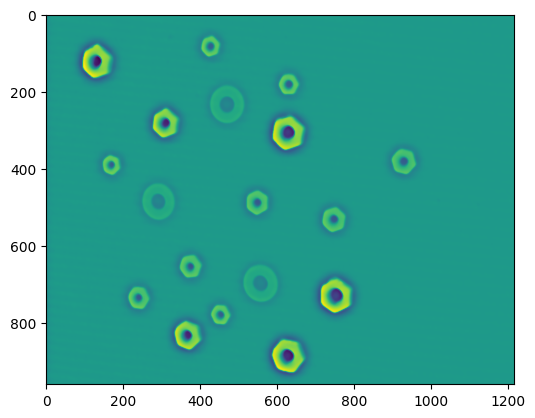

In [ ]:
#@title
train_data = scipy.io.loadmat('/content/drive/MyDrive/Investigacion/Data/MATLAB/3D/reconstruction12.mat')
Spz, XcM, YcM = train_data['Spz'], train_data['XcM'], train_data['YcM']
plt.imshow(Spz)

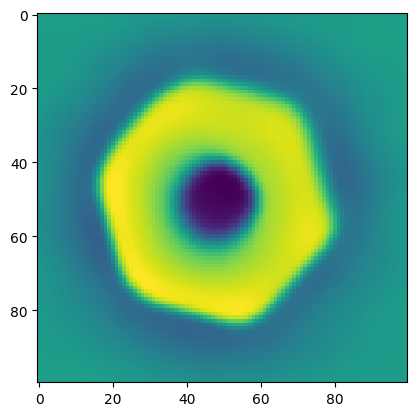

In [ ]:
preprocessor = Preprocessor()
x, y, crop_size = (880, 332, 100)
Zcrop = preprocessor.crop(Spz, x, y, crop_size)
plt.imshow(Zcrop)

------------------------------------
# 3D Transformations

In [ ]:
# Generate the transformation matrix
def generate_transformation_matrix(ax, ay, az, tx, ty, tz):
    ax = ax * np.pi / 180
    ay = ay * np.pi / 180
    az = az * np.pi / 180

    Rrec = np.array([
        [np.cos(ay) * np.cos(az), np.sin(ax) * np.sin(ay) * np.cos(az) - np.cos(ax) * np.sin(az),
         np.cos(ax) * np.sin(ay) * np.cos(az) + np.sin(ax) * np.sin(az)],
        [np.cos(ay) * np.sin(az), np.sin(ax) * np.sin(ay) * np.sin(az) + np.cos(ax) * np.cos(az),
         np.cos(ax) * np.sin(ay) * np.sin(az) - np.sin(ax) * np.cos(az)],
        [-np.sin(ay), np.sin(ax) * np.cos(ay), np.cos(ax) * np.cos(ay)]
    ])
    tras = np.array([tx, ty, tz])
    Mext_rec = np.concatenate((Rrec, tras.reshape(3, 1)), axis=1)
    Mext_rec = np.vstack((Mext_rec, np.array([0, 0, 0, 1])))

    return Mext_rec

# Transform the points using the transformation matrix
def transform_points(Mext_rec, Xcrop, Ycrop, Zcrop):
    xcrop = Xcrop.flatten()
    ycrop = Ycrop.flatten()
    zcrop = Zcrop.flatten()
    P = np.vstack((xcrop, ycrop))
    P = np.vstack((P, zcrop))

    zeros_file = np.zeros(xcrop.shape[0] - 1)
    last_file = np.hstack((zeros_file, np.array([1])))

    P = np.vstack((P, last_file))
    P_rot = Mext_rec @ P

    return P, P_rot[:3, :]

# Generate a random transformation within the specified angle ranges
def generate_random_transformation(angle_ranges):
    ax = np.random.uniform(angle_ranges['ax'][0], angle_ranges['ax'][1])
    ay = np.random.uniform(angle_ranges['ay'][0], angle_ranges['ay'][1])
    az = np.random.uniform(angle_ranges['az'][0], angle_ranges['az'][1])
    tx = np.random.uniform(angle_ranges['tx'][0], angle_ranges['tx'][1])
    ty = np.random.uniform(angle_ranges['ty'][0], angle_ranges['ty'][1])
    tz = np.random.uniform(angle_ranges['tz'][0], angle_ranges['tz'][1])

    return generate_transformation_matrix(ax, ay, az, tx, ty, tz)

def generate_transformed_images(image_to_transform, crop_coords, angle_ranges, N):
    transformed_images = []
    transformed_crops = []

    for _ in range(N):
        # Generate a random transformation
        Mext_rec = generate_random_transformation(angle_ranges)

        # Transform the image using the generated transformation matrix
        P, P_rot_3D = transform_points(Mext_rec, XcM, YcM, image_to_transform)
        transformed_image = P_rot_3D[2, :].reshape(Spz.shape)
        transformed_crop = preprocessor.crop(transformed_image, *crop_coords)

        transformed_images.append(transformed_image)
        transformed_crops.append(transformed_crop)

    # Display the transformed images and crops
    fig, axes = plt.subplots(2, N, figsize=(12, 6))

    for i in range(N):
        axes[0, i].imshow(transformed_images[i])
        axes[0, i].set_title(f'Transformed Image {i + 1}')

        axes[1, i].imshow(transformed_crops[i])
        axes[1, i].set_title(f'Transformed Crop {i + 1}')

    plt.tight_layout()
    plt.show()

    return transformed_images, transformed_crops

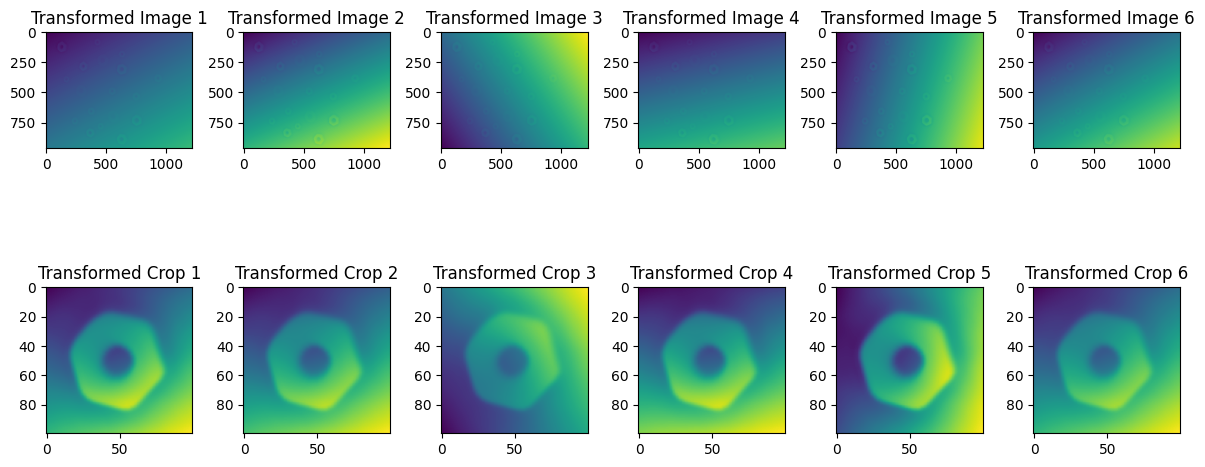

In [ ]:
# TODO: To generate more examples


# Set the image, crop coordinates, and angle ranges
N = 6
image_to_transform = Spz
crop_coords = (880, 332, 100)
angle_ranges = {'ax': (-5, 5), 'ay': (-5, 5), 'az': (-5, 5), 'tx': (-50, 50), 'ty': (-50, 50), 'tz': (-50, 50)}

# Generate a list of N transformed images and transformed crops
# Generate and display the transformed images and crops
transformed_images, transformed_crops = generate_transformed_images(image_to_transform, crop_coords, angle_ranges, N)

------------------

# Model Training

In [ ]:
size_object = 100 # 100
wide = 20 # size of the training template
downsample = size_object // wide

### Some 2D transformations

In [ ]:
transformations = (
    #Add:  dt.ElasticTransformation
    dt.Affine(translate=lambda:np.random.uniform(-1.5, 1.5, 2), rotate=lambda: np.random.rand()*np.pi*2),
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)), # Very sensitive
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2)) # 0.3, 1.6
)

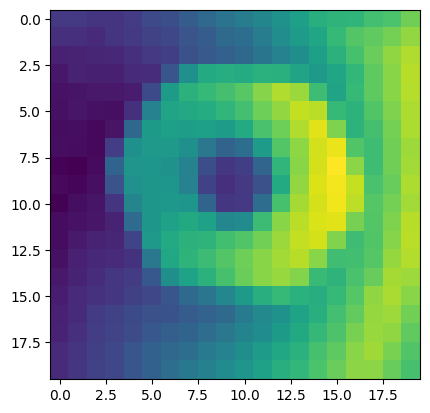

In [ ]:
train_set = preprocessor.create_train_data(transformed_crops, transformations)

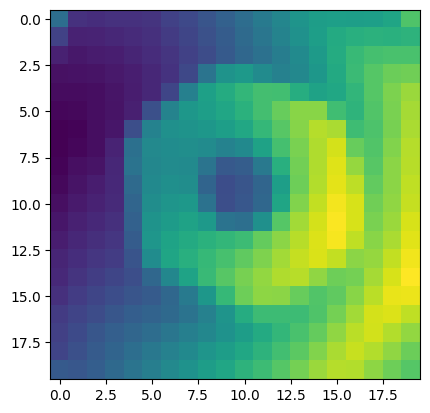

In [ ]:
image = train_set.update()()
plt.imshow(image)

In [ ]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/3D_transformations'
trainer = Trainer(filepath)

In [ ]:
history = trainer.fit(train_set, epochs=30)

Generating 161 / 160 samples before starting training
Epoch 1/30
161/161 [==============================] - 19s 22ms/step - total_loss: 1.8893 - consistency_loss: 0.6005 - lr: 0.0010
Epoch 2/30
161/161 [==============================] - 8s 51ms/step - total_loss: 1.3210 - consistency_loss: 0.3318 - lr: 0.0010                           
Epoch 3/30
161/161 [==============================] - 6s 38ms/step - total_loss: 0.7968 - consistency_loss: 0.1577 - lr: 0.0010                          
Epoch 4/30
161/161 [==============================] - 8s 49ms/step - total_loss: 0.2570 - consistency_loss: 0.0477 - lr: 0.0010                           
Epoch 5/30
161/161 [==============================] - 7s 46ms/step - total_loss: 0.0635 - consistency_loss: 0.0104 - lr: 0.0010                          
Epoch 6/30
161/161 [==============================] - 8s 52ms/step - total_loss: 0.0484 - consistency_loss: 0.0066 - lr: 0.0010                          
Epoch 7/30
161/161 [=========================

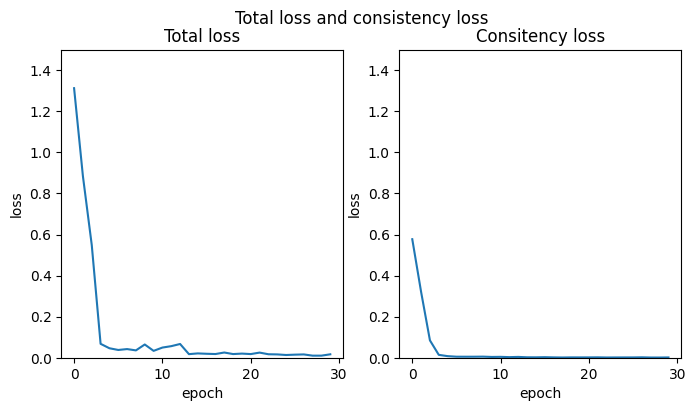

In [ ]:
trainer.plot_performance(history)

In [ ]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/3D_transformations'
trainer = Trainer(filepath)
trainer.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
trainer.model.load_weights(filepath)

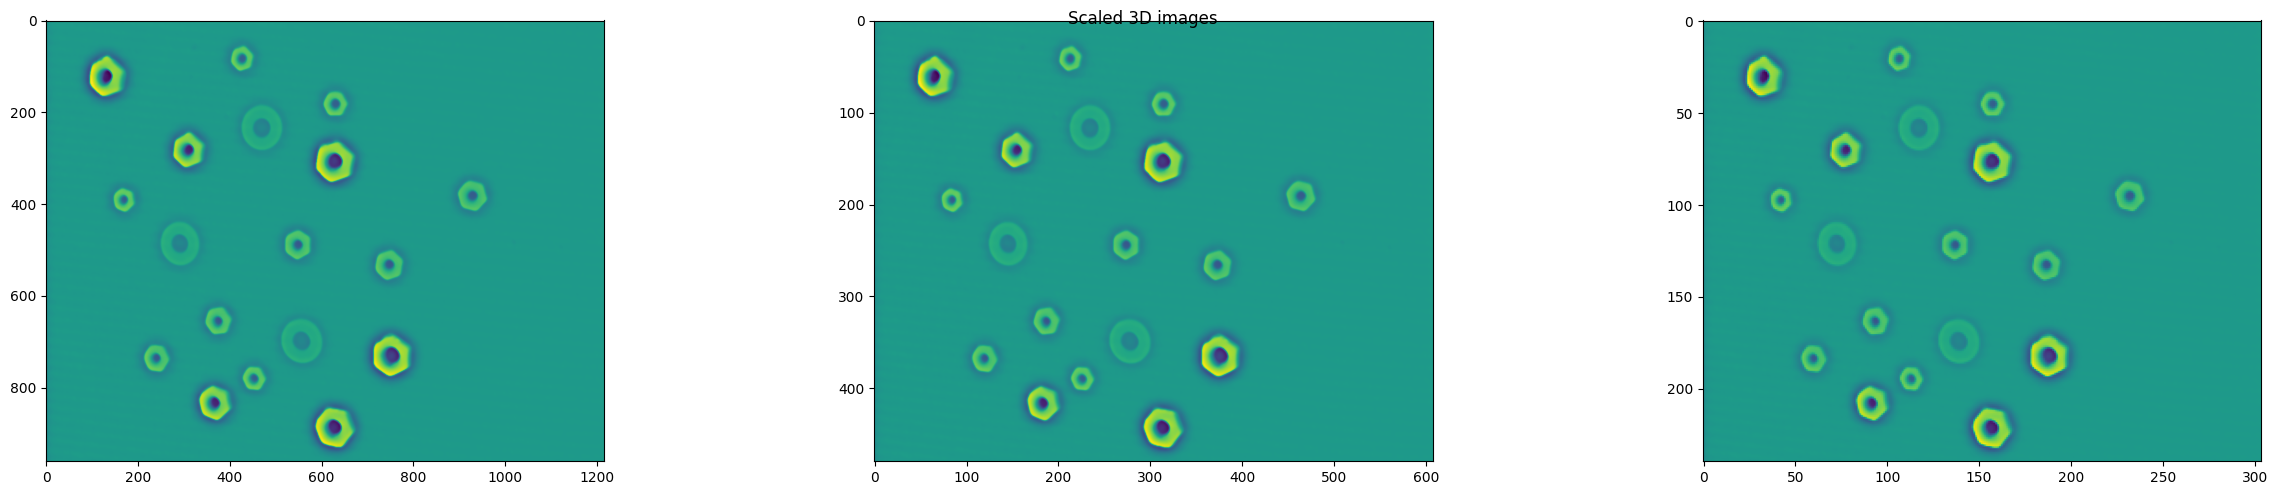

In [ ]:
test_data = scipy.io.loadmat('/content/drive/MyDrive/Investigacion/Data/MATLAB/3D/reconstruction12.mat')
preprocessor = Preprocessor()
input_set = preprocessor.load_images(test_data['Spz'])

1/1 [==============================] - 0s 68ms/step


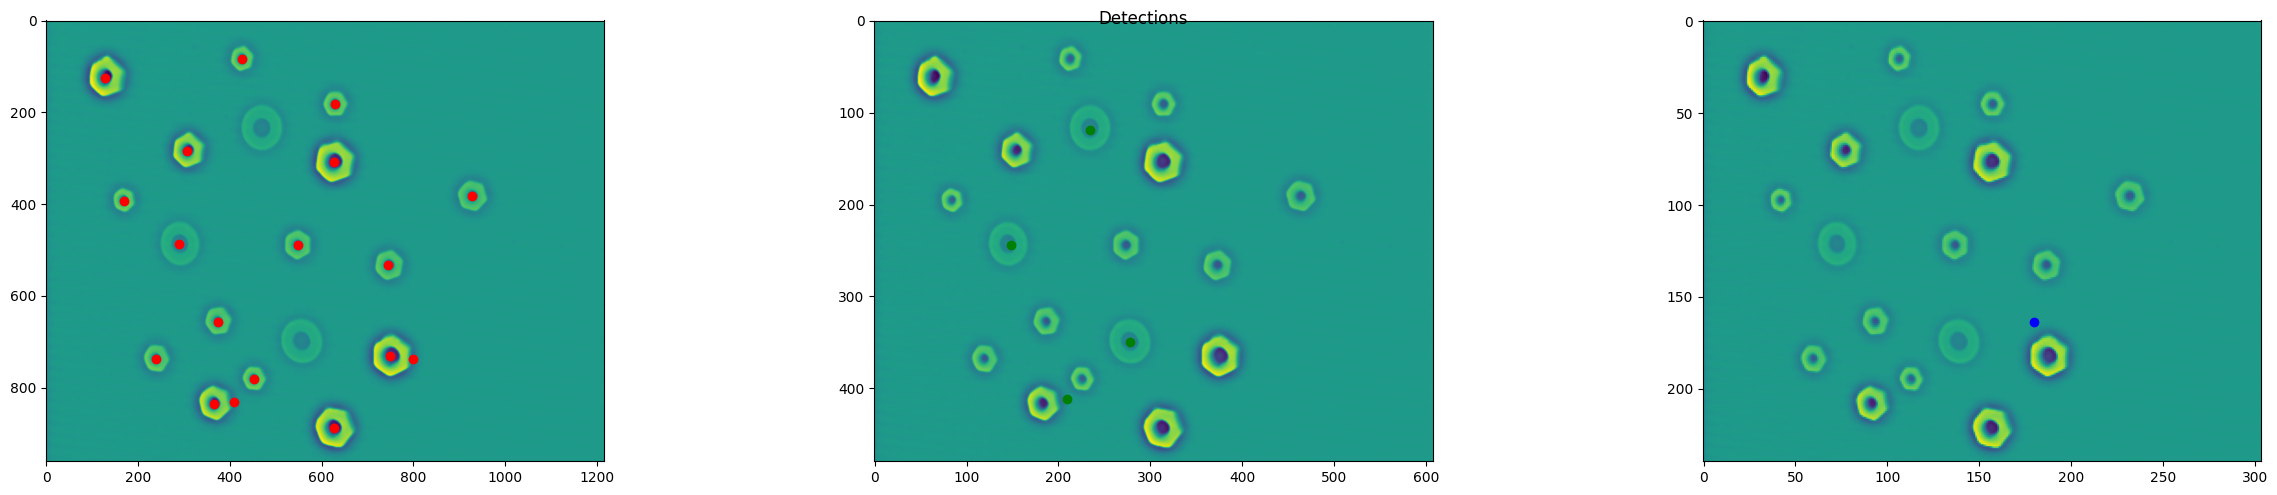

In [ ]:
# Detection settings
alpha = 0.1 # 0.1
cutoff = 0.996 # 0.99
mode = "quantile"
detector = Detector(downsample, model=trainer.model, alpha=alpha, cutoff=cutoff, mode=mode)
detections = detector.detect_all(input_set, plot=True)

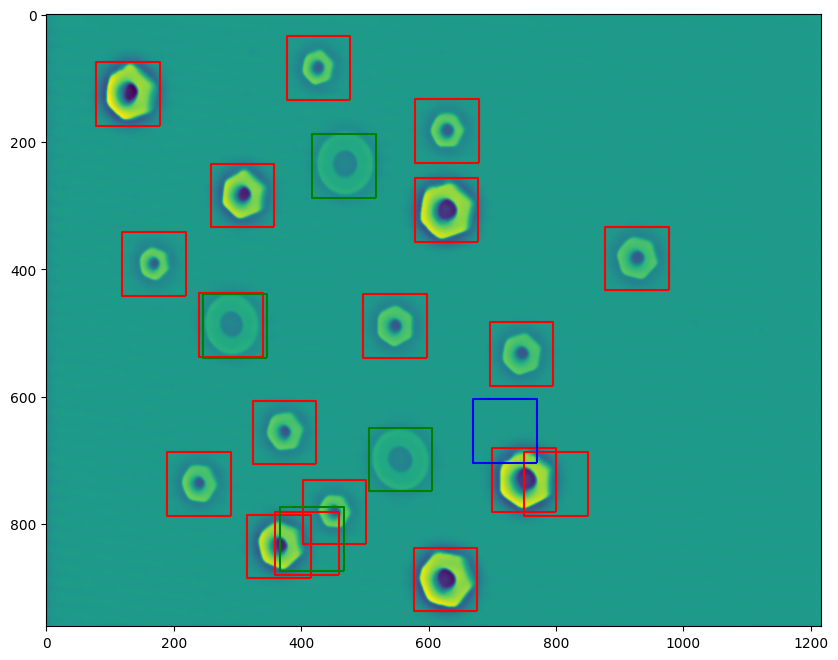

In [ ]:
postprocessor = Postprocessor()
test_image = input_set[0]
bounds = postprocessor.plot_boxes(test_image, detections, figsize=(10,10))

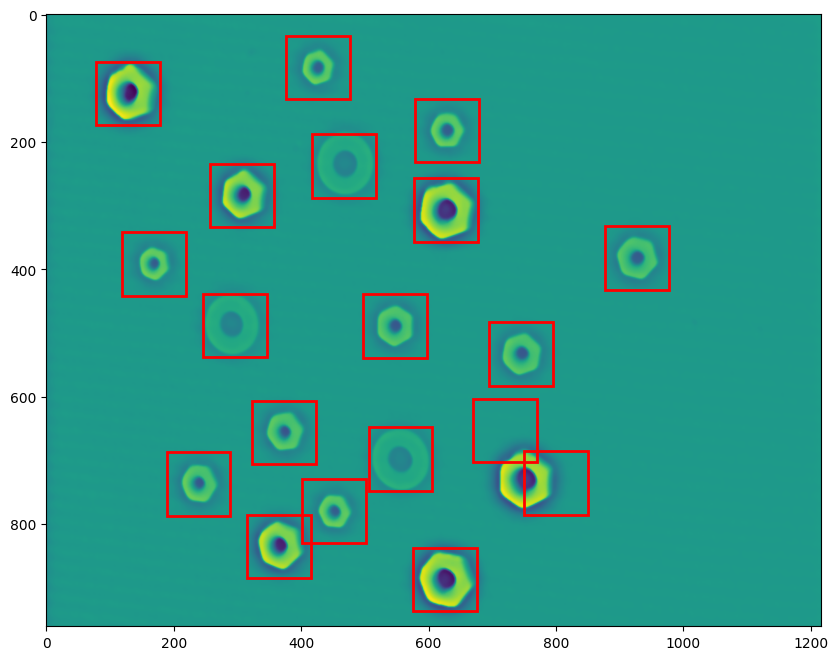

In [ ]:
final_detections = postprocessor.apply_nms(test_image, bounds, figsize=(10,10))

## Testing with 3D transformed images

In [ ]:
test_set = transformed_images
len(test_set)

6

In [ ]:
#@title
def test(test_data, model, downsample=1, alpha=0.1, cutoff=0.99, mode="quantile", plotPrevious=True):
  preprocessor = Preprocessor()
  input_set = preprocessor.load_images(test_data, plot=plotPrevious)
  detector = Detector(downsample, model=model, alpha=alpha, cutoff=cutoff, mode=mode)
  detections = detector.detect_all(input_set, plot=plotPrevious)
  postprocessor = Postprocessor()
  test_image = input_set[0]
  bounds = postprocessor.plot_boxes(test_image, detections, plot=plotPrevious)
  final_detections = postprocessor.apply_nms(test_image, bounds, figsize = (8,8))

  return final_detections

1/1 [==============================] - 0s 21ms/step


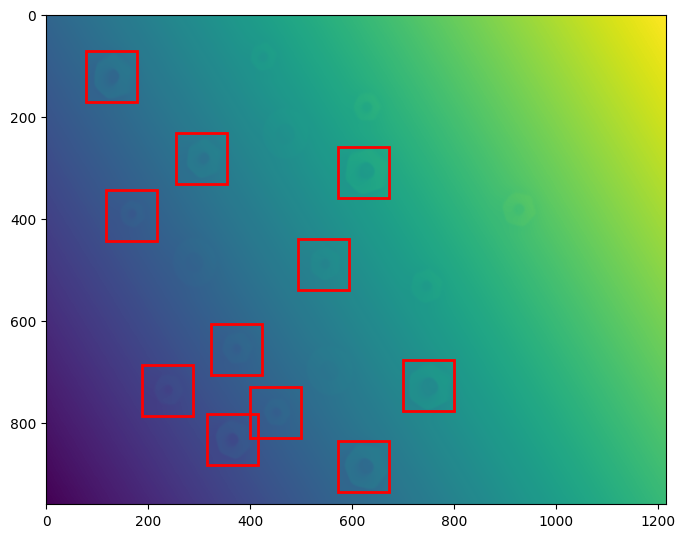

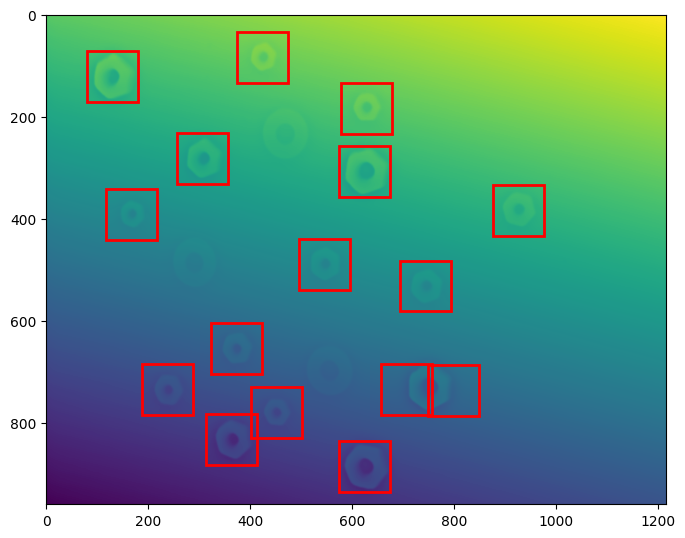

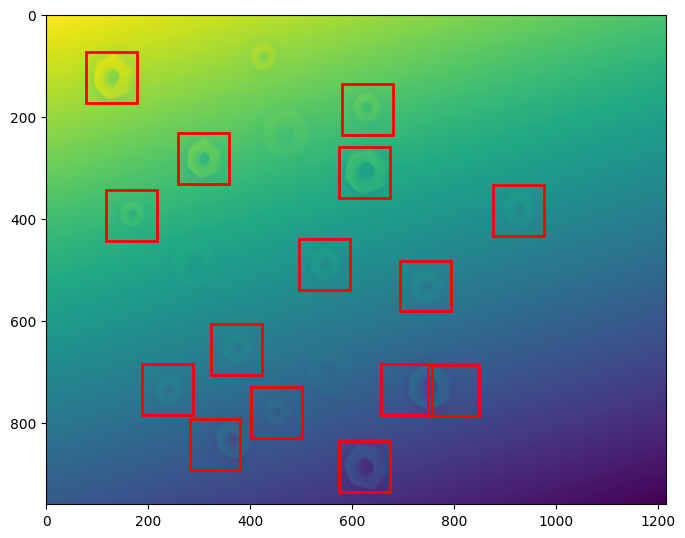

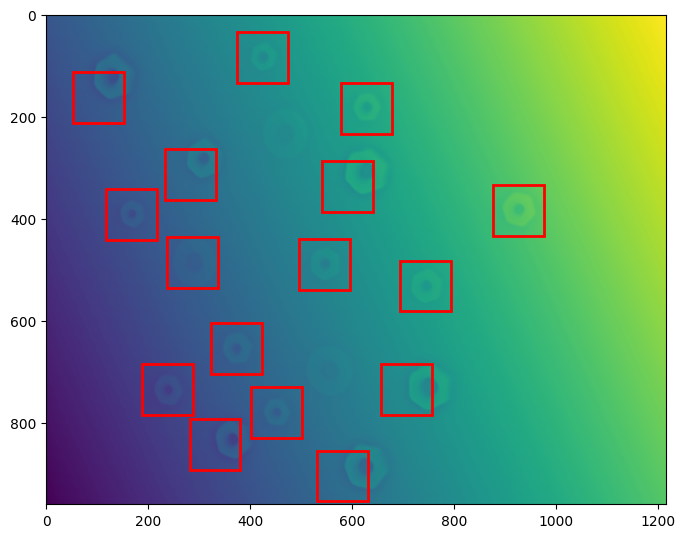

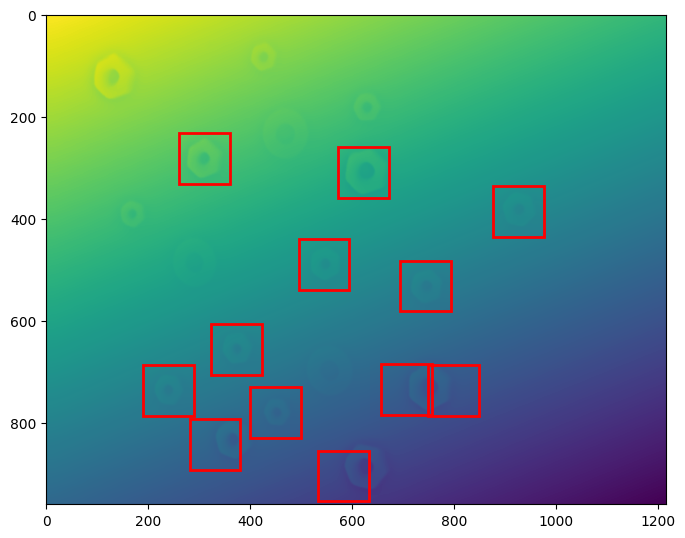

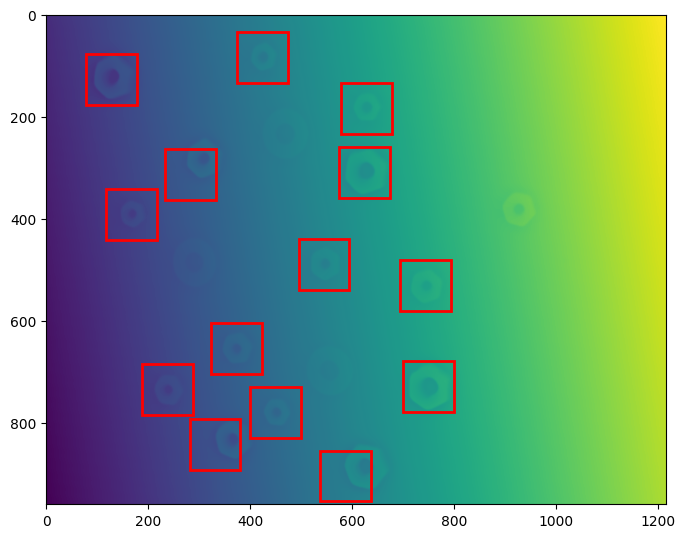

In [ ]:
# Detection settings
alpha = 0.1 # 0.1
cutoff = 0.992 # 0.9985
mode = "quantile"

for idx in range(len(test_set)):
  final_detections = test(test_set[idx], trainer.model, downsample=2, alpha=alpha, cutoff=cutoff, plotPrevious=False)